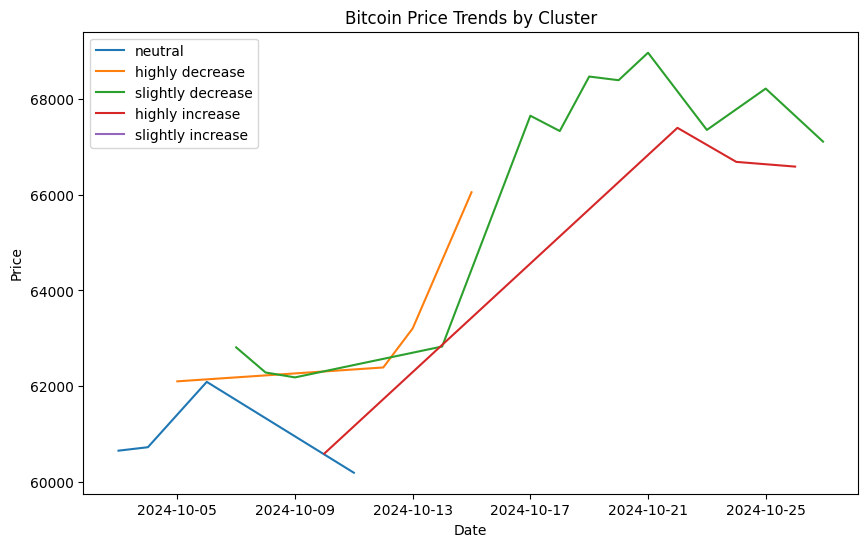

Data for Bitcoin:
    timestamp         price        trend_label
6  2024-10-03  60655.559792            neutral
7  2024-10-04  60727.863952            neutral
8  2024-10-05  62103.010473    highly decrease
9  2024-10-06  62091.932585            neutral
10 2024-10-07  62811.799728  slightly decrease


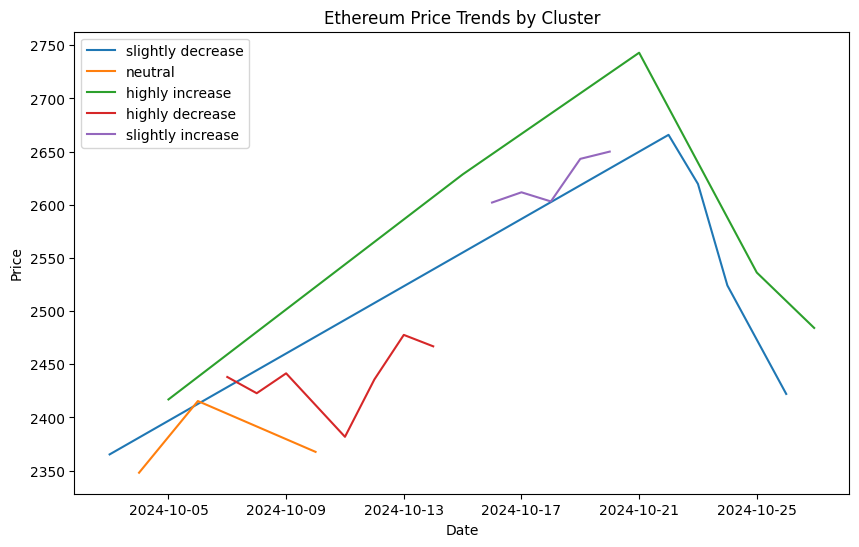

Data for Ethereum:
    timestamp        price        trend_label
6  2024-10-03  2365.231040  slightly decrease
7  2024-10-04  2348.004837            neutral
8  2024-10-05  2416.918406    highly increase
9  2024-10-06  2415.403814            neutral
10 2024-10-07  2438.030913    highly decrease


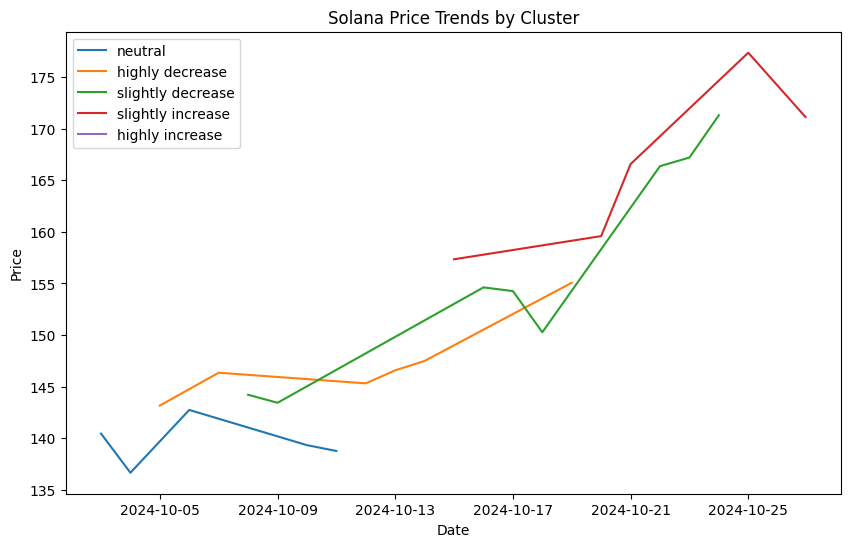

Data for Solana:
    timestamp       price      trend_label
6  2024-10-03  140.448433          neutral
7  2024-10-04  136.653936          neutral
8  2024-10-05  143.164768  highly decrease
9  2024-10-06  142.740665          neutral
10 2024-10-07  146.348536  highly decrease


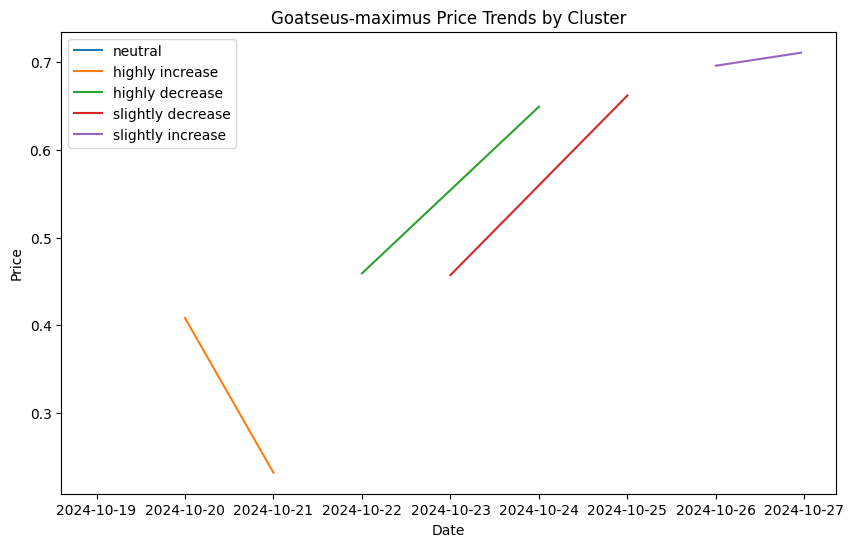

Data for Goatseus-maximus:
    timestamp     price        trend_label
6  2024-10-19  0.415872            neutral
7  2024-10-20  0.408106    highly increase
8  2024-10-21  0.231487    highly increase
9  2024-10-22  0.459099    highly decrease
10 2024-10-23  0.457104  slightly decrease
Model for bitcoin saved as kmeans_model_bitcoin.pkl
Model for ethereum saved as kmeans_model_ethereum.pkl
Model for solana saved as kmeans_model_solana.pkl
Model for goatseus-maximus saved as kmeans_model_goatseus-maximus.pkl


In [6]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

# List of coins to analyze
coin_ids = ['bitcoin', 'ethereum', 'solana', 'goatseus-maximus']

# Parameters for historical data
params = {
    'vs_currency': 'usd',
    'days': '30',
    'interval': 'daily'
}

# Dictionary to store data for each coin and list to store models
all_coin_data = {}
models = []

for coin in coin_ids:
    # Step 1: Fetch Historical Data for each coin
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # Load data into DataFrame
        data = pd.DataFrame(response.json()['prices'], columns=['timestamp', 'price'])
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

        # Step 2: Calculate Features for Clustering
        data['price_change'] = data['price'].diff()
        data['pct_change'] = data['price'].pct_change() * 100
        data['volatility'] = data['price'].rolling(window=3).std()  # 3-day volatility
        data['7_day_avg'] = data['price'].rolling(window=7).mean()  # 7-day moving average
        data['momentum'] = data['pct_change'].rolling(window=5).sum()  # 5-day momentum

        # Drop rows with NaN values due to rolling calculations
        data.dropna(inplace=True)

        # Step 3: Prepare Data for Clustering
        features = data[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)

        # Step 4: Apply KMeans Clustering
        kmeans = KMeans(n_clusters=5, random_state=42)
        data['trend_cluster'] = kmeans.fit_predict(scaled_features)

        # Map each cluster to a label for interpretability
        data['trend_label'] = data['trend_cluster'].map({
            0: 'highly decrease',
            1: 'slightly decrease',
            2: 'neutral',
            3: 'slightly increase',
            4: 'highly increase'
        })

        # Store data and model for each coin
        all_coin_data[coin] = data
        models.append(kmeans)  # Append each model to the list

        # Step 5: Plot Clusters for each coin
        plt.figure(figsize=(10, 6))
        for label in data['trend_label'].unique():
            plt.plot(data[data['trend_label'] == label]['timestamp'],
                     data[data['trend_label'] == label]['price'],
                     label=label)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{coin.capitalize()} Price Trends by Cluster')
        plt.legend()
        plt.show()

        # Display the clustered data with trend labels for each coin
        print(f"Data for {coin.capitalize()}:")
        print(data[['timestamp', 'price', 'trend_label']].head())

    else:
        print(f"Failed to fetch data for {coin}: {response.status_code}")

# Step 6: Save all models to separate .pkl files
for idx, model in enumerate(models):
    with open(f'kmeans_model_{coin_ids[idx]}.pkl', 'wb') as file:
        pickle.dump(model, file)
    print(f"Model for {coin_ids[idx]} saved as kmeans_model_{coin_ids[idx]}.pkl")

# You can load any model from these files as follows:
# with open('kmeans_model_bitcoin.pkl', 'rb') as file:
#     bitcoin_model = pickle.load(file)


In [7]:
import numpy as np

# Assuming we want to predict for 'bitcoin'
coin = 'bitcoin'
model_path = f'kmeans_model_{coin}.pkl'

# Load the saved KMeans model
with open(model_path, 'rb') as file:
    kmeans_model = pickle.load(file)

# Also assume the scaler used during training
scaler = StandardScaler()  # Note: this needs to be the same scaler used in training

# Extract the latest data point from the coin's data for prediction
# For demonstration, we assume `all_coin_data[coin]` contains historical data with features
latest_data = all_coin_data[coin].iloc[-7:]  # Using the last 7 days for calculation
features_for_prediction = {
    'price_change': latest_data['price'].diff().iloc[-1],
    'pct_change': latest_data['price'].pct_change().iloc[-1] * 100,
    'volatility': latest_data['price'].rolling(window=3).std().iloc[-1],
    '7_day_avg': latest_data['price'].rolling(window=7).mean().iloc[-1],
    'momentum': latest_data['pct_change'].rolling(window=5).sum().iloc[-1]
}

# Convert to DataFrame
features_df = pd.DataFrame([features_for_prediction])

# Scale features using the same scaler used during training
scaled_features = scaler.fit_transform(features_df)

# Predict the trend cluster
predicted_cluster = kmeans_model.predict(scaled_features)

# Map the cluster number back to the trend label
trend_labels = {
    0: 'highly decrease',
    1: 'slightly decrease',
    2: 'neutral',
    3: 'slightly increase',
    4: 'highly increase'
}

predicted_trend = trend_labels[predicted_cluster[0]]
print(f"The predicted trend for {coin.capitalize()} for the next day is: {predicted_trend}")



The predicted trend for Bitcoin for the next day is: slightly decrease


In [10]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

# List of coins to analyze
coin_ids = ['bitcoin', 'ethereum', 'solana', 'polkadot', 'cardano']

# Function to fetch historical data (without current day) with delay handling
def fetch_historical_data(coin, days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }

    # Retry logic to handle 429 errors
    for attempt in range(5):
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an error for bad responses
            data = pd.DataFrame(response.json()['prices'], columns=['timestamp', 'price'])
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
            return data.iloc[:-1] if not data.empty else None  # Exclude today's data
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                print(f"Rate limit exceeded for {coin}. Retrying in {attempt + 1} seconds...")
                time.sleep(attempt + 1)  # Exponential backoff
            else:
                print(f"Error fetching data for {coin}: {e}")
                return None
    return None

# Function to calculate clustering features
def calculate_features(data):
    data['price_change'] = data['price'].diff()
    data['pct_change'] = data['price'].pct_change() * 100
    data['volatility'] = data['price'].rolling(window=3).std()  # 3-day volatility
    data['7_day_avg'] = data['price'].rolling(window=7).mean()  # 7-day moving average
    data['momentum'] = data['pct_change'].rolling(window=5).sum()  # 5-day momentum
    return data.dropna()

# Initialize model storage
models = {}

# Training phase: Iterate over each coin, train and save models
for coin in coin_ids:
    historical_data = fetch_historical_data(coin)
    if historical_data is not None and not historical_data.empty:
        features_data = calculate_features(historical_data)
        features = features_data[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']]

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(scaled_features)

        models[coin] = {'model': kmeans, 'scaler': scaler}
        print(f"Model for {coin.capitalize()} trained and saved.")
    else:
        print(f"No historical data available for {coin}.")

# Backtesting: Testing with current day’s data
for coin in coin_ids:
    full_data = fetch_historical_data(coin)
    if full_data is not None and not full_data.empty:
        current_features = calculate_features(full_data.iloc[-7:])  # Use last 7 days to calculate current features
        features_for_prediction = current_features[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']].iloc[-1:]

        kmeans = models[coin]['model']
        scaler = models[coin]['scaler']

        scaled_current_features = scaler.transform(features_for_prediction)
        predicted_cluster = kmeans.predict(scaled_current_features)

        trend_labels = {
            0: 'highly decrease',
            1: 'slightly decrease',
            2: 'neutral',
            3: 'slightly increase',
            4: 'highly increase'
        }
        predicted_trend = trend_labels[predicted_cluster[0]]
        print(f"Predicted trend for {coin.capitalize()} for the current day is: {predicted_trend}")
    else:
        print(f"No data available for predicting trend for {coin}.")


Rate limit exceeded for bitcoin. Retrying in 1 seconds...
Rate limit exceeded for bitcoin. Retrying in 2 seconds...
Rate limit exceeded for bitcoin. Retrying in 3 seconds...
Rate limit exceeded for bitcoin. Retrying in 4 seconds...
Rate limit exceeded for bitcoin. Retrying in 5 seconds...
No historical data available for bitcoin.
Rate limit exceeded for ethereum. Retrying in 1 seconds...
Rate limit exceeded for ethereum. Retrying in 2 seconds...
Rate limit exceeded for ethereum. Retrying in 3 seconds...
Model for Ethereum trained and saved.
Rate limit exceeded for solana. Retrying in 1 seconds...
Model for Solana trained and saved.
Model for Polkadot trained and saved.
Model for Cardano trained and saved.
Rate limit exceeded for bitcoin. Retrying in 1 seconds...
Rate limit exceeded for bitcoin. Retrying in 2 seconds...
Rate limit exceeded for bitcoin. Retrying in 3 seconds...
Rate limit exceeded for bitcoin. Retrying in 4 seconds...
Rate limit exceeded for bitcoin. Retrying in 5 second

KeyboardInterrupt: 

Model for Bitcoin trained and saved.


<ipython-input-15-90e6398081ac>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_data['cluster'] = kmeans.labels_


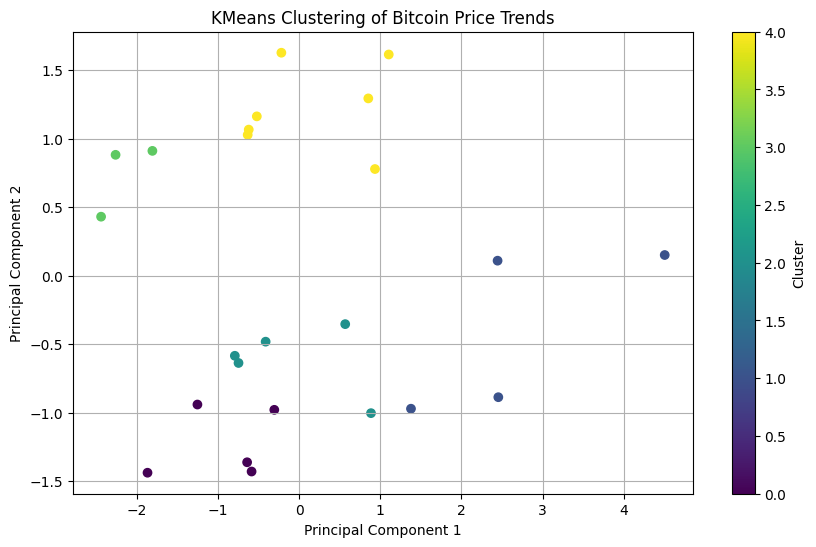

Predicted trend for Bitcoin for the current day is: slightly increase


<ipython-input-15-90e6398081ac>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_change'] = data['price'].diff()
<ipython-input-15-90e6398081ac>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct_change'] = data['price'].pct_change() * 100
<ipython-input-15-90e6398081ac>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [15]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import random

# Coin to analyze
coin_id = 'bitcoin'

# Function to fetch historical data (excluding current day)
def fetch_historical_data(coin, days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }

    # Retry logic to handle 429 errors
    for attempt in range(5):
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an error for bad responses
            data = pd.DataFrame(response.json()['prices'], columns=['timestamp', 'price'])
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
            return data.iloc[:-1] if not data.empty else None  # Exclude today's data
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                print(f"Rate limit exceeded for {coin}. Retrying in {attempt + 1} seconds...")
                time.sleep(attempt + 1 + random.uniform(0, 2))  # Adding a random delay
            else:
                print(f"Error fetching data for {coin}: {e}")
                return None
    return None

# Function to calculate clustering features
def calculate_features(data):
    data['price_change'] = data['price'].diff()
    data['pct_change'] = data['price'].pct_change() * 100
    data['volatility'] = data['price'].rolling(window=3).std()  # 3-day volatility
    data['7_day_avg'] = data['price'].rolling(window=7).mean()  # 7-day moving average
    data['momentum'] = data['pct_change'].rolling(window=5).sum()  # 5-day momentum
    return data.dropna()

# Fetch historical data for the coin
historical_data = fetch_historical_data(coin_id)
if historical_data is not None and not historical_data.empty:
    # Calculate features for clustering
    features_data = calculate_features(historical_data)
    features = features_data[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']]

    # Standardize features and fit the KMeans model
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(scaled_features)

    print(f"Model for {coin_id.capitalize()} trained and saved.")

    # Adding cluster labels to the original features data
    features_data['cluster'] = kmeans.labels_

    # Visualizing the clusters using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)

    # Creating a DataFrame for plotting
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['cluster'] = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', marker='o')
    plt.title(f'KMeans Clustering of {coin_id.capitalize()} Price Trends')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid()
    plt.show()

    # Backtesting: Testing with current day’s data
    full_data = fetch_historical_data(coin_id)
    if full_data is not None and not full_data.empty:
        current_features = calculate_features(full_data.iloc[-7:])  # Use last 7 days to calculate current features
        features_for_prediction = current_features[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']].iloc[-1:]

        # Standardize current features and predict
        scaled_current_features = scaler.transform(features_for_prediction)
        predicted_cluster = kmeans.predict(scaled_current_features)

        # Map predicted cluster to trend label
        trend_labels = {
            0: 'highly decrease',
            1: 'slightly decrease',
            2: 'neutral',
            3: 'slightly increase',
            4: 'highly increase'
        }
        predicted_trend = trend_labels[predicted_cluster[0]]
        print(f"Predicted trend for {coin_id.capitalize()} for the current day is: {predicted_trend}")
    else:
        print(f"No data available for predicting trend for {coin_id.capitalize()}.")
else:
    print(f"No historical data available for {coin_id.capitalize()}.")


Model for Bitcoin trained.
Model and scaler for Bitcoin saved as .pkl files.


<ipython-input-16-10ce399c0913>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_data['cluster'] = kmeans.labels_


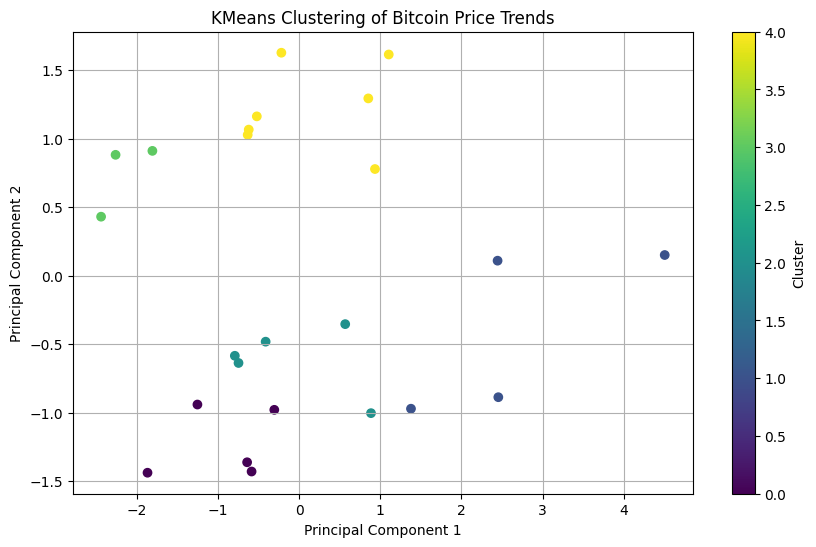

Predicted trend for Bitcoin for the current day is: slightly increase


<ipython-input-16-10ce399c0913>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_change'] = data['price'].diff()
<ipython-input-16-10ce399c0913>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct_change'] = data['price'].pct_change() * 100
<ipython-input-16-10ce399c0913>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [16]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import random
import pickle  # Importing pickle for saving the model

# Coin to analyze
coin_id = 'bitcoin'

# Function to fetch historical data (excluding current day)
def fetch_historical_data(coin, days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }

    # Retry logic to handle 429 errors
    for attempt in range(5):
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an error for bad responses
            data = pd.DataFrame(response.json()['prices'], columns=['timestamp', 'price'])
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
            return data.iloc[:-1] if not data.empty else None  # Exclude today's data
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                print(f"Rate limit exceeded for {coin}. Retrying in {attempt + 1} seconds...")
                time.sleep(attempt + 1 + random.uniform(0, 2))  # Adding a random delay
            else:
                print(f"Error fetching data for {coin}: {e}")
                return None
    return None

# Function to calculate clustering features
def calculate_features(data):
    data['price_change'] = data['price'].diff()
    data['pct_change'] = data['price'].pct_change() * 100
    data['volatility'] = data['price'].rolling(window=3).std()  # 3-day volatility
    data['7_day_avg'] = data['price'].rolling(window=7).mean()  # 7-day moving average
    data['momentum'] = data['pct_change'].rolling(window=5).sum()  # 5-day momentum
    return data.dropna()

# Fetch historical data for the coin
historical_data = fetch_historical_data(coin_id)
if historical_data is not None and not historical_data.empty:
    # Calculate features for clustering
    features_data = calculate_features(historical_data)
    features = features_data[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']]

    # Standardize features and fit the KMeans model
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(scaled_features)

    print(f"Model for {coin_id.capitalize()} trained.")

    # Save the model and scaler to .pkl files
    with open(f'kmeans_model_{coin_id}.pkl', 'wb') as model_file:
        pickle.dump(kmeans, model_file)
    with open(f'scaler_{coin_id}.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)

    print(f"Model and scaler for {coin_id.capitalize()} saved as .pkl files.")

    # Adding cluster labels to the original features data
    features_data['cluster'] = kmeans.labels_

    # Visualizing the clusters using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)

    # Creating a DataFrame for plotting
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['cluster'] = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', marker='o')
    plt.title(f'KMeans Clustering of {coin_id.capitalize()} Price Trends')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid()
    plt.show()

    # Backtesting: Testing with current day’s data
    full_data = fetch_historical_data(coin_id)
    if full_data is not None and not full_data.empty:
        current_features = calculate_features(full_data.iloc[-7:])  # Use last 7 days to calculate current features
        features_for_prediction = current_features[['price_change', 'pct_change', 'volatility', 'momentum', '7_day_avg']].iloc[-1:]

        # Standardize current features and predict
        scaled_current_features = scaler.transform(features_for_prediction)
        predicted_cluster = kmeans.predict(scaled_current_features)

        # Map predicted cluster to trend label
        trend_labels = {
            0: 'highly decrease',
            1: 'slightly decrease',
            2: 'neutral',
            3: 'slightly increase',
            4: 'highly increase'
        }
        predicted_trend = trend_labels[predicted_cluster[0]]
        print(f"Predicted trend for {coin_id.capitalize()} for the current day is: {predicted_trend}")
    else:
        print(f"No data available for predicting trend for {coin_id.capitalize()}.")
else:
    print(f"No historical data available for {coin_id.capitalize()}.")
